In [121]:
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
env = gym.make("Pendulum-v1")

## Un premier Algorithme REINFORCE

Définition des hyperparamètres

In [122]:
## Hyperparametres
env.reset()

learning_rate = 2**(-1)
gamma = 0.95
sigma = 0.1
num_episodes = 1200
max_steps = 200


np.random.seed(0)
theta = np.random.randn(env.observation_space.shape[0])

# {'learning_rate': 0.003, 'gamma': 0.95, 'sigma': 0.1}


Définition de la politique et fonction de mise à jour des gains (récompenses cumulées)

-La politique est une fonction linéaire des caractéristiques de l’état, pondérées par les composantes de theta

-sigma est l'écart-type de la distribution gaussienne, servant à ajouter de l’exploration aléatoire

In [123]:
##Politique (distribution normale car l'espace des actions est continu)
def policy(state, theta):
    return np.dot(state, theta)

def choose_action(state, theta):
    mean_action = policy(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])

##discounted returns
def compute_returns(rewards):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns

Implémentation de REINFORCE

[   497.74830344 -10385.46997966 239758.97873798]


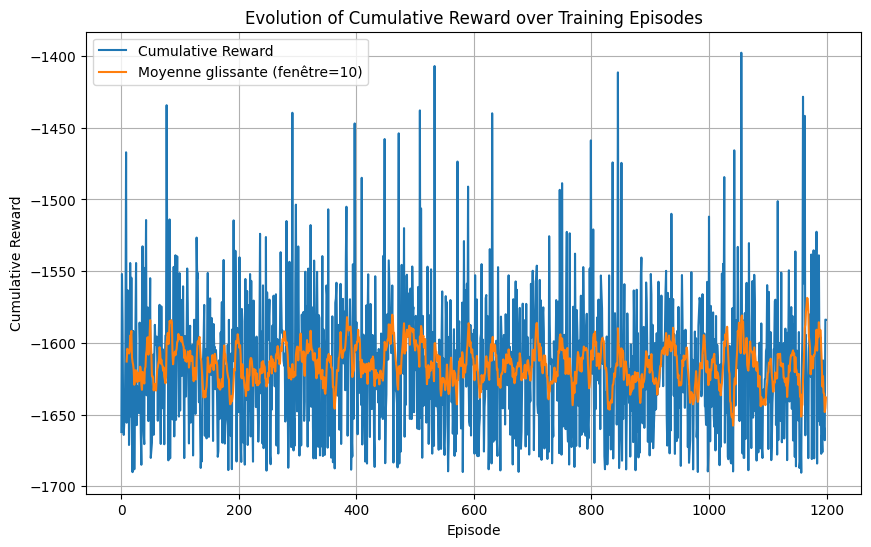

In [124]:
##REINFORCE
def reinforce(env, theta, learning_rate, gamma, sigma, num_episodes):
    cumulative_rewards = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        states, actions, rewards = deque(), deque(), deque()
        # Generation d'un épisode complet
        truncated = False
        for step in range(max_steps):
            action = choose_action(state, theta)
            next_state, reward, _, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if truncated:
                break
        returns = compute_returns(np.array(rewards))
        # descente de gradient
        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            G = returns[t]
            mean_action = policy(state, theta)
            grad_log_policy = (action - mean_action) / (sigma ** 2) * state
            grad_update = learning_rate * gamma ** t * G * grad_log_policy
            theta += np.clip(grad_update, -1, 1)
        cumulative_rewards.append(sum(rewards))
    return theta, cumulative_rewards


optimal_theta, cumulative_rewards = reinforce(env, theta, learning_rate, gamma, sigma, num_episodes)
print(optimal_theta, )

##affichage
plt.figure(figsize=(10, 6))
plt.plot(cumulative_rewards, label='Cumulative Reward')
episodes = np.arange(len(cumulative_rewards))
window = 10
moving_avg = np.convolve(cumulative_rewards, np.ones(window)/window, mode='valid')
plt.plot(episodes[window-1:], moving_avg, label="Moyenne glissante (fenêtre=10)")
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Evolution of Cumulative Reward over Training Episodes')
plt.legend()
plt.grid(True)
plt.show()

On constate une variance très élevée de la somme des récompenses. Néanmoins, la moyenne glissée permet de lire plus aisément ce tracé. Nous verrons ci dessous des techniques pour réduire la variance.

On peut évaluer la politique finale en approximant $J(\theta)$ et en visualisant $G_t$ au cours du temps:


Training REINFORCE with lr=0.003, gamma=0.95:
Estimated total return for lr=0.003, gamma=0.95: -101.15

Training REINFORCE with lr=0.005, gamma=0.95:
Estimated total return for lr=0.005, gamma=0.95: -104.08

Training REINFORCE with lr=0.007, gamma=0.95:
Estimated total return for lr=0.007, gamma=0.95: -134.39

Training REINFORCE with lr=0.009, gamma=0.95:
Estimated total return for lr=0.009, gamma=0.95: -109.19

Evaluating Random Policy:


<ipython-input-100-7fe2553243fd>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rewards.append(float(reward))


Estimated total return for Random Policy: -109.88


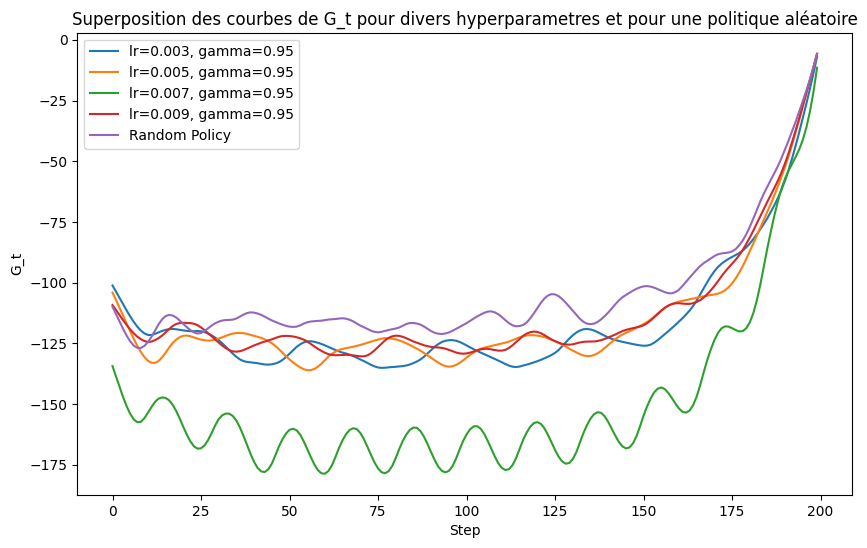

In [100]:
def policy_v2(state, theta):
    return np.dot(state, theta)

def choose_action_v2(state, theta, sigma):
    mean_action = policy_v2(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])

def compute_returns_v2(rewards, gamma):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0.0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns

def reinforce_v2(env, theta, learning_rate, gamma, sigma, num_episodes, max_steps):
    cumulative_rewards = []
    current_sigma = sigma
    current_lr = learning_rate
    for episode in range(num_episodes):
        state, _ = env.reset()
        states, actions, rewards = deque(), deque(), deque()
        for step in range(max_steps):
            action = choose_action_v2(state, theta, current_sigma)
            next_state, reward, terminated, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(float(reward))
            state = next_state
            if terminated or truncated:
                break
        returns = compute_returns_v2(np.array(rewards), gamma)
        for t in range(len(states)):
            s = states[t]
            a = actions[t]
            G = returns[t]
            mean_action = policy(s, theta)
            grad_log_policy = ((a - mean_action) / (current_sigma ** 2)) * s
            grad_update = current_lr * (gamma ** t) * G * grad_log_policy
            # Clip the gradient update to prevent large jumps
            grad_update = np.clip(grad_update, -10, 10)
            # Optional L2 regularization
            regularization = 1e-4 * theta
            theta += grad_update - regularization
        cumulative_rewards.append(sum(rewards))
        # print(f"[REINFORCE] Episode {episode+1}/{num_episodes} - Reward: {sum(rewards):.2f}")
    return theta, cumulative_rewards

def evaluate_policy_Gt(env, policy_func, gamma=0.99, num_eval_episodes=10, max_steps=200):
    returns_list = []
    G_curves = []
    for _ in range(num_eval_episodes):
        state, _ = env.reset()
        rewards = []
        for _ in range(max_steps):
            action = policy_func(state)
            next_state, reward, terminated, truncated, _ = env.step([action])
            rewards.append(float(reward))
            state = next_state
            if terminated or truncated:
                break
        rewards = np.array(rewards)
        G_t = compute_returns_v2(rewards, gamma)
        returns_list.append(G_t[0])
        G_curves.append(G_t)
    avg_return = np.mean(returns_list)
    min_length = min(len(curve) for curve in G_curves)
    avg_curve = np.mean([curve[:min_length] for curve in G_curves], axis=0)
    return avg_return, avg_curve

def random_policy(state):
    return env.action_space.sample()

num_episodes = 500
max_steps = 200
obs_dim = env.observation_space.shape[0]

hyperparams = [
    {"label": "lr=0.003, gamma=0.95", "lr": 0.003, "gamma": 0.95, "sigma": 2.0},
    {"label": "lr=0.005, gamma=0.95", "lr": 0.005, "gamma": 0.95, "sigma": 2.0},
    {"label": "lr=0.007, gamma=0.95", "lr": 0.007, "gamma": 0.95, "sigma": 2.0},
    {"label": "lr=0.009, gamma=0.95", "lr": 0.009, "gamma": 0.95, "sigma": 2.0}
]

Gt_curves = {}

for params in hyperparams:
    print(f"\nTraining REINFORCE with {params['label']}:")
    theta_init = np.zeros(obs_dim)
    theta_trained, _ = reinforce_v2(env, theta_init,
                                          params["lr"],
                                          params["gamma"],
                                          params["sigma"],
                                          num_episodes, max_steps)
    policy_func = lambda state: np.clip(policy(state, theta_trained),
                                        env.action_space.low[0], env.action_space.high[0])
    avg_return, G_curve = evaluate_policy_Gt(env, policy_func, gamma=params["gamma"],
                                             num_eval_episodes=20, max_steps=max_steps)
    print(f"Estimated total return for {params['label']}: {avg_return:.2f}")
    Gt_curves[params["label"]] = G_curve

print("\nEvaluating Random Policy:")
avg_return_random, G_curve_random = evaluate_policy_Gt(env, random_policy, gamma=0.95,
                                                       num_eval_episodes=20, max_steps=max_steps)
print(f"Estimated total return for Random Policy: {avg_return_random:.2f}")
Gt_curves["Random Policy"] = G_curve_random

env.close()

plt.figure(figsize=(10, 6))
for label, curve in Gt_curves.items():
    plt.plot(curve, label=label)
plt.xlabel("Step")
plt.ylabel("G_t")
plt.title("Superposition des courbes de G_t pour divers hyperparametres et pour une politique aléatoire")
plt.legend()
plt.show()

## Optimisation des hyperparamètres

In [103]:
from itertools import product

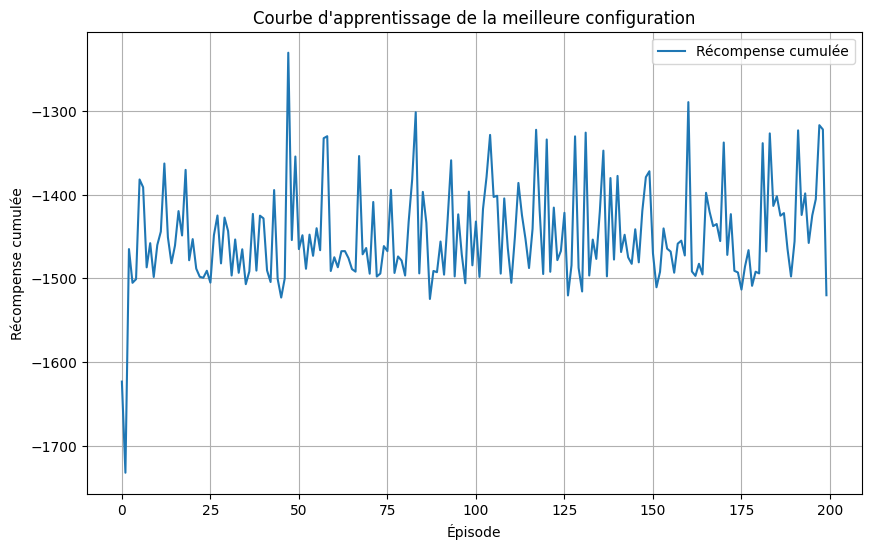

Meilleure configuration : {'learning_rate': 0.005, 'gamma': 0.95, 'sigma': 0.005, 'num_episodes': 200, 'sigma_decrease_rate': 0.95, 'sigma_min': 0.01, 'max_step': 200}


In [104]:
env.reset()

hyperparams_grid = {
    "learning_rate": [0.05,0.01,0.005],
    "gamma": [0.9,0.95],
    "sigma":  [0.1,0.01,0.005],
    "num_episodes": [200],
    "sigma_decrease_rate": [0.95,0.99],
    "sigma_min":  [0.05,0.01,0.005],
    "max_step": [200]
}

def grid_search_with_baseline(env, hyperparams_grid):
    best_reward = -np.inf
    best_params = None
    best_theta = None
    best_rewards_curve = None
    results = []

    keys = list(hyperparams_grid.keys())
    values = [hyperparams_grid[key] for key in keys]
    for idx, combination in enumerate(product(*values)):
        params = dict(zip(keys, combination))
        theta_init = np.random.randn(env.observation_space.shape[0])
        theta_opt, rewards = reinforce_linear_with_baseline(
            env,
            theta_init,
            params["learning_rate"],
            params["gamma"],
            params["sigma"],
            params["num_episodes"],
            params["sigma_decrease_rate"],
            params["sigma_min"],
            params["max_step"]
        )
        avg_reward = np.mean(rewards[-10:])
        results.append({
            "params": params,
            "avg_reward": avg_reward,
            "theta": theta_opt,
            "rewards": rewards
        })
        if avg_reward > best_reward:
            best_reward = avg_reward
            best_params = params
            best_theta = theta_opt
            best_rewards_curve = rewards
    episodes = np.arange(len(best_rewards_curve))
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, best_rewards_curve, label="Récompense cumulée")
    plt.xlabel("Épisode")
    plt.ylabel("Récompense cumulée")
    plt.title("Courbe d'apprentissage de la meilleure configuration")
    plt.legend()
    plt.grid(True)
    plt.show()
    return best_params, best_theta, results

best_params, best_theta, results = grid_search_with_baseline(env, hyperparams_grid)
print("Meilleure configuration :", best_params)

On constate une nette amélioration des récompenses cumulées en moyenne par rapport à l'algorithme REINFORCE standard codé ci-dessus.

## REINFORCEMENT with Baseline

Une première Baseline : moyenne des retours passés

In [125]:
# Hyperparametres
env.reset()

LEARNING_RATE = 2**(-1)
GAMMA = 0.95
SIGMA = 0.1
SIGMA_DECREASE_RATE = 0.95
SIGMA_MIN = 0.02
MAX_STEPS = 200
NUM_EPISODES = 1200



def policy_baseline(state, theta):
    return np.dot(state, theta)

def choose_action_baseline(state, theta, sigma=sigma):
    mean_action = policy(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])



def compute_returns_baseline(rewards, gamma):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns


def reinforce_linear_with_baseline(env, theta, learning_rate, gamma, sigma, num_episodes,
                                   sigma_decrease_rate, sigma_min, max_steps):

    cumulative_rewards = []
    current_sigma = sigma

    for episode in range(num_episodes):
        state, _ = env.reset()
        states, actions, rewards = deque(), deque(), deque()
        for step in range(max_steps):
            action = choose_action_baseline(state, theta, current_sigma)
            next_state, reward, terminated, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if terminated or truncated:
                break

        returns = compute_returns_baseline(np.array(rewards), gamma)
        baseline = np.mean(returns)  # baseline: moyenne des retours passés

        for t in range(len(states)):
            s = states[t]
            a = actions[t]
            G = returns[t]
            advantage = G - baseline
            mean_action = policy(s, theta)
            grad_log_policy = ((a - mean_action) / (current_sigma ** 2)) * s
            grad_update = learning_rate * (gamma ** t) * advantage * grad_log_policy
            theta += np.clip(grad_update, -1, 1)
        cumulative_rewards.append(np.sum(rewards))
        current_sigma = max(sigma_min, current_sigma * sigma_decrease_rate)
    return theta, cumulative_rewards


optimal_theta, cumulative_rewards = reinforce_linear_with_baseline(
    env, theta, LEARNING_RATE, GAMMA, SIGMA, NUM_EPISODES,
    SIGMA_DECREASE_RATE, SIGMA_MIN, MAX_STEPS)


print("Optimal Theta:", optimal_theta)

Optimal Theta: [   491.74830344  26936.53002034 331294.97873798]


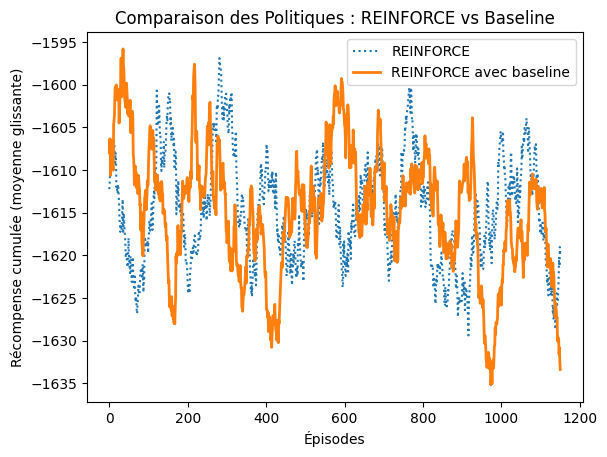

In [127]:
theta0 = np.random.randn(env.observation_space.shape[0])
np.random.seed(0)

optimal_theta, train_rewards_reinforce = reinforce(env, theta0, LEARNING_RATE, GAMMA, SIGMA, NUM_EPISODES)


optimal_theta_baseline, train_rewards_reinforce_baseline = reinforce_linear_with_baseline(
    env, theta0, LEARNING_RATE, GAMMA, SIGMA, NUM_EPISODES,
    SIGMA_DECREASE_RATE, SIGMA_MIN, MAX_STEPS)

# moyenne glissante (fenêtre de 50 épisodes)
def smooth_curve(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.plot(smooth_curve(train_rewards_reinforce), label="REINFORCE", linestyle="dotted")
plt.plot(smooth_curve(train_rewards_reinforce_baseline), label="REINFORCE avec baseline", linewidth=2)

plt.xlabel("Épisodes")
plt.ylabel("Récompense cumulée (moyenne glissante)")
plt.title("Comparaison des Politiques : REINFORCE vs Baseline")
plt.legend()
plt.show()

## Comparaison avec et sans baseline

Une première baseline avec la moyenne des récompenses discountées passées

In [129]:

def policy(state, theta):
    return np.dot(state, theta)

def choose_action(state, theta, sigma):
    mean_action = policy(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])
def compute_returns(rewards, gamma):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns
def policy_baseline(state, theta):
    return np.dot(state, theta)

def choose_action_baseline(state, theta, sigma):
    mean_action = policy_baseline(state, theta)
    action = np.random.normal(mean_action, sigma)
    return np.clip(action, env.action_space.low[0], env.action_space.high[0])

def compute_returns_baseline(rewards, gamma):
    returns = np.zeros_like(rewards, dtype=float)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns


In [140]:

def compare_reinforce_algorithms(env, theta, learning_rate, gamma, sigma, num_episodes,
                                 sigma_decrease_rate, sigma_min, max_steps):

    def reinforce(env, theta, learning_rate, gamma, sigma, num_episodes):
        theta=theta0
        cumulative_rewards = []

        for episode in range(num_episodes):
            state = env.reset()[0]
            states, actions, rewards = deque(), deque(), deque()

            for step in range(max_steps):
                action = choose_action(state, theta, sigma)
                next_state, reward, _, truncated, _ = env.step([action])
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                state = next_state
                if truncated:
                    break

            returns = compute_returns(np.array(rewards), gamma)
            for t in range(len(states)):
                state = states[t]
                action = actions[t]
                G = returns[t]
                mean_action = policy(state, theta)
                grad_log_policy = (action - mean_action) / (sigma ** 2) * state
                grad_update = learning_rate * gamma ** t * G * grad_log_policy
                theta += np.clip(grad_update, -1, 1)

            cumulative_rewards.append(sum(rewards))

        return cumulative_rewards

    def reinforce_with_baseline(env, theta, learning_rate, gamma, sigma, num_episodes,
                                sigma_decrease_rate, sigma_min, max_steps):
        theta = theta0
        cumulative_rewards = []
        current_sigma = sigma
        for episode in range(num_episodes):
            state = env.reset()[0]
            states, actions, rewards = deque(), deque(), deque()
            for step in range(max_steps):
                action = choose_action_baseline(state, theta, current_sigma)
                next_state, reward, _, truncated, _ = env.step([action])
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                state = next_state
                if truncated:
                    break
            returns = compute_returns(np.array(rewards), gamma)
            baseline = np.mean(returns)
            for t in range(len(states)):
                state = states[t]
                action = actions[t]
                G = returns[t]
                advantage = G - baseline
                mean_action = policy(state, theta)
                grad_log_policy = ((action - mean_action) / (current_sigma ** 2)) * state
                grad_update = learning_rate * (gamma ** t) * advantage * grad_log_policy
                theta += np.clip(grad_update, -1, 1)
            cumulative_rewards.append(sum(rewards))
            current_sigma = max(sigma_min, current_sigma * sigma_decrease_rate)
        return cumulative_rewards


    rewards_no_baseline = reinforce(env, np.copy(theta), learning_rate, gamma, sigma, num_episodes)
    rewards_with_baseline = reinforce_with_baseline(env, np.copy(theta), learning_rate, gamma, sigma, num_episodes,
                                                    sigma_decrease_rate, sigma_min, max_steps)

    plt.figure(figsize=(10, 6))
    plt.plot(rewards_no_baseline, label="REINFORCE sans baseline")
    plt.plot(rewards_with_baseline, label="REINFORCE avec baseline")

    window = 10
    moving_avg_no_baseline = np.convolve(rewards_no_baseline, np.ones(window) / window, mode='valid')
    moving_avg_with_baseline = np.convolve(rewards_with_baseline, np.ones(window) / window, mode='valid')

    plt.plot(np.arange(window - 1, num_episodes), moving_avg_no_baseline, label="Moyenne glissante sans baseline")
    plt.plot(np.arange(window - 1, num_episodes), moving_avg_with_baseline, label="Moyenne glissante avec baseline")

    plt.xlabel('Épisode')
    plt.ylabel('Récompense cumulée')
    plt.title('Comparaison de REINFORCE avec et sans baseline')
    plt.legend()
    plt.grid(True)
    plt.show()


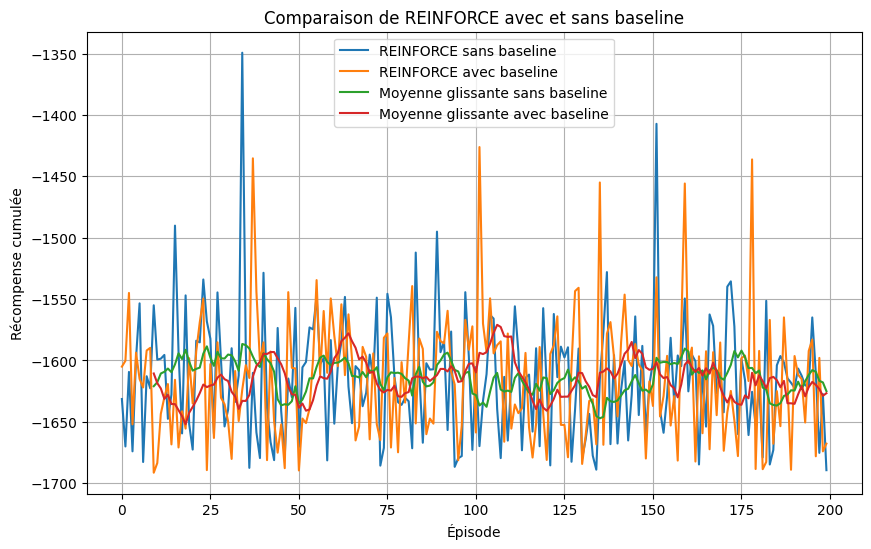

In [132]:
env.reset()
theta0 = np.random.randn(env.observation_space.shape[0])
LEARNING_RATE = 0.05
GAMMA = 0.95
SIGMA = 0.1
NUM_EPISODES = 200
SIGMA_DECREASE_RATE = 0.95
SIGMA_MIN = 0.05
MAX_STEPS = 200
compare_reinforce_algorithms(env, theta0, LEARNING_RATE, GAMMA, SIGMA, NUM_EPISODES,
                             SIGMA_DECREASE_RATE, SIGMA_MIN, MAX_STEPS)

Les résultats sont comparables entre REINFORCE standard et REINFORCE avec cette premiere baseline. Cette première baseline semble assez limitée.

## Comparaison avec une seconde Baseline

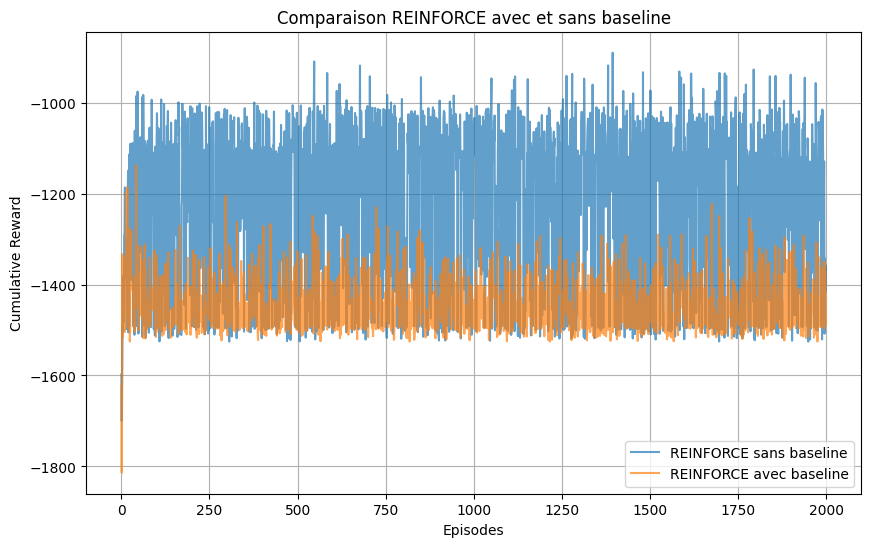

In [146]:
env.reset()

# Hyperparamètres
learning_rate = 0.05
gamma = 0.95
sigma = 0.1
num_episodes = 2000
sigma_decrease_rate = 0.95
sigma_min = 0.02
max_steps = 200

# initialisation
theta0 = np.random.randn(env.observation_space.shape[0])
baseline = 0

def reinforce_baseline_parametre(env, theta, learning_rate, gamma, sigma, num_episodes, use_baseline=False):
    cumulative_rewards = []
    global baseline

    for episode in range(num_episodes):
        state = env.reset()[0]
        states, actions, rewards = deque(), deque(), deque()

        for step in range(max_steps):
            action = choose_action(theta, state, sigma)
            next_state, reward, _, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if truncated:
                break

        returns = np.zeros_like(rewards, dtype=float)
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + gamma * G
            returns[t] = G

        if use_baseline:
            baseline = 0.9 * baseline + 0.1 * np.mean(returns)  # mise à jour de la baseline

        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            G = returns[t]
            advantage = G - baseline if use_baseline else G
            mean_action = np.dot(theta, state)
            grad_log_policy = (action - mean_action) / (sigma ** 2) * state
            grad_update = learning_rate * gamma ** t * advantage * grad_log_policy
            theta += np.clip(grad_update, -1, 1)

        cumulative_rewards.append(np.sum(rewards))

    return cumulative_rewards


rewards_no_baseline = reinforce_baseline_parametre(env, theta0.copy(), learning_rate, gamma, sigma, num_episodes, use_baseline=False)
rewards_with_baseline = reinforce_baseline_parametre(env, theta0.copy(), learning_rate, gamma, sigma, num_episodes, use_baseline=True)

# affichage
plt.figure(figsize=(10, 6))
plt.plot(rewards_no_baseline, label="REINFORCE sans baseline", alpha=0.7)
plt.plot(rewards_with_baseline, label="REINFORCE avec baseline", alpha=0.7)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Comparaison REINFORCE avec et sans baseline")
plt.legend()
plt.grid()
plt.show()


Cette baseline ci est plus intéressante car on constate clairement son effet de réduction de variance ainsi que une accelération de la convergence de l'algorithme.

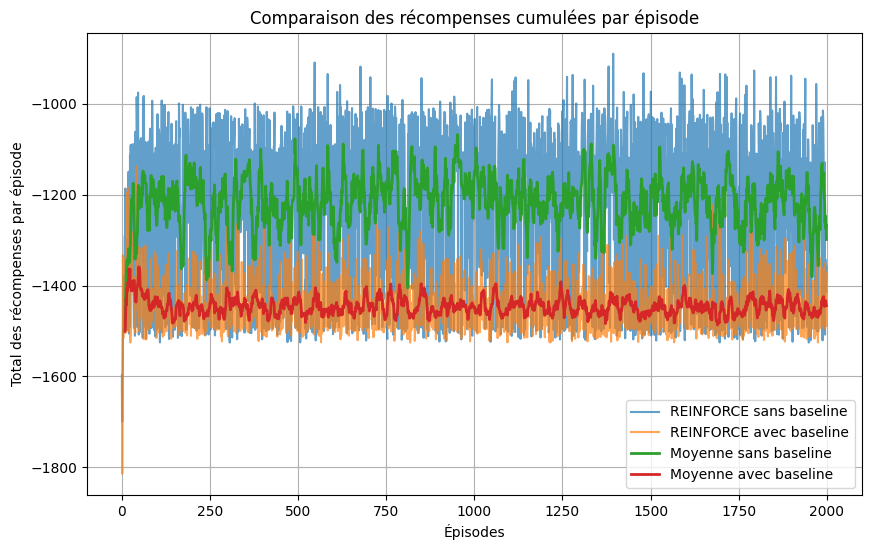

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_no_baseline, label="REINFORCE sans baseline", alpha=0.7)
plt.plot(rewards_with_baseline, label="REINFORCE avec baseline", alpha=0.7)


window = 10
moving_avg_no_baseline = np.convolve(rewards_no_baseline, np.ones(window) / window, mode='valid')
moving_avg_with_baseline = np.convolve(rewards_with_baseline, np.ones(window) / window, mode='valid')

plt.plot(range(window-1, len(rewards_no_baseline)), moving_avg_no_baseline, label="Moyenne sans baseline", linewidth=2)
plt.plot(range(window-1, len(rewards_with_baseline)), moving_avg_with_baseline, label="Moyenne avec baseline", linewidth=2)
plt.xlabel("Épisodes")
plt.ylabel("Total des récompenses par épisode")
plt.title("Comparaison des récompenses cumulées par épisode")
plt.legend()
plt.grid(True)
plt.show()


Moyenne glissante ci dessus pour faciliter la lecture du graphe.

## Comparaison avec learning rate qui diminue

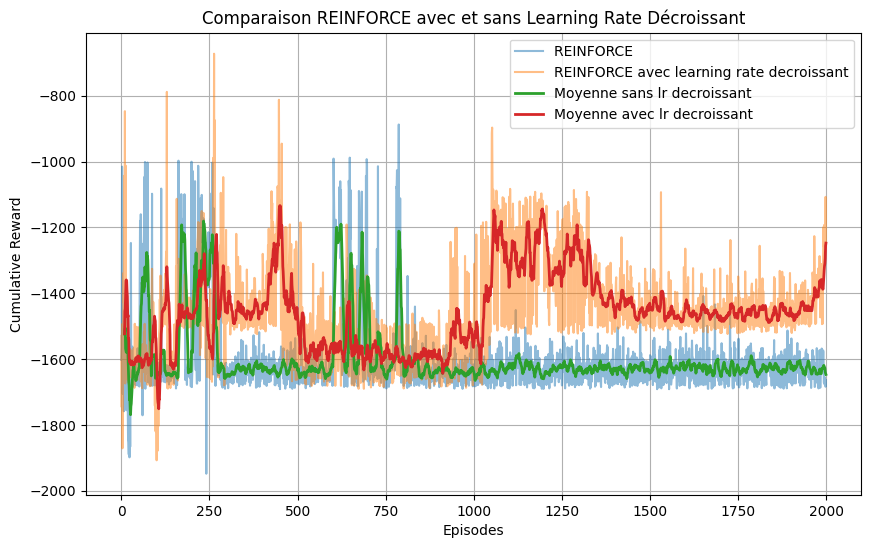

In [171]:
env.reset()

# Hyperparamètres
initial_learning_rate = 0.05
gamma = 0.95
sigma = 0.1
num_episodes = 2000
sigma_decrease_rate = 0.95
sigma_min = 0.02
max_steps = 200

# initialisation
theta0 = np.random.randn(env.observation_space.shape[0])
baseline = 0

def reinforce_with_lr(env, theta, learning_rate, gamma, sigma, num_episodes, use_baseline=False):
    cumulative_rewards = []
    global baseline

    for episode in range(num_episodes):
        state = env.reset()[0]
        states, actions, rewards = deque(), deque(), deque()

        for step in range(max_steps):
            action = choose_action_baseline(theta, state, sigma)
            next_state, reward, _, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if truncated:
                break

        returns = np.zeros_like(rewards, dtype=float)
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + gamma * G
            returns[t] = G

        if use_baseline:
            baseline = 0.9 * baseline + 0.1 * np.mean(returns)

        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            G = returns[t]
            advantage = G - baseline if use_baseline else G
            mean_action = np.dot(theta, state)
            grad_log_policy = (action - mean_action) / (sigma ** 2) * state
            grad_update = learning_rate * (gamma ** t) * advantage * grad_log_policy
            theta += np.clip(grad_update, -1, 1)

        cumulative_rewards.append(np.sum(rewards))

        learning_rate = max(0.001, learning_rate * 0.95)

    return cumulative_rewards


rewards = reinforce_baseline_parametre(env, theta0.copy(), learning_rate, gamma, sigma, num_episodes, use_baseline=False)
rewards_with_lr = reinforce_with_lr(env, theta0.copy(), initial_learning_rate, gamma, sigma, num_episodes, use_baseline=False)


plt.figure(figsize=(10, 6))
plt.plot(rewards, label="REINFORCE ", alpha=0.5)
plt.plot(rewards_with_lr, label="REINFORCE avec learning rate decroissant", alpha=0.5)
window = 10
smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
smoothed_with_with_lr = np.convolve(rewards_with_lr, np.ones(window)/window, mode='valid')

plt.plot(range(window-1, len(rewards)), smoothed, label="Moyenne sans lr decroissant", linewidth=2)
plt.plot(range(window-1, len(rewards_with_lr)), smoothed_with_with_lr, label="Moyenne avec lr decroissant", linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Comparaison REINFORCE avec et sans Learning Rate Décroissant")
plt.legend()
plt.grid()
plt.show()


## Comparaison avec gamma qui diminue

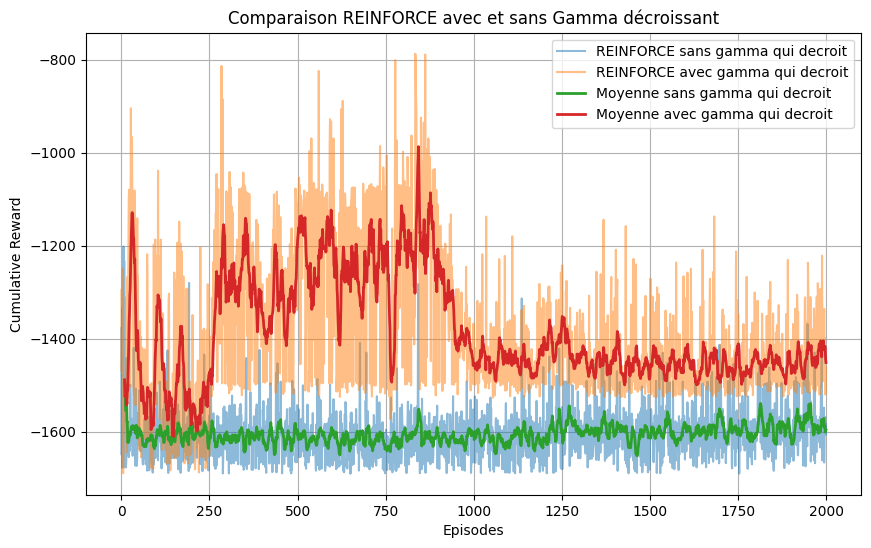

In [175]:
env.reset()

# Hyperparamètres
learning_rate = 0.05
initial_gamma = 0.95
sigma = 0.1
num_episodes = 2000
sigma_decrease_rate = 0.95
sigma_min = 0.02
max_steps = 200

theta0 = np.random.randn(env.observation_space.shape[0])
baseline = 0

def reinforce_with_gamma(env, theta, learning_rate, gamma, sigma, num_episodes, use_baseline=False):
    cumulative_rewards = []
    global baseline

    for episode in range(num_episodes):
        state = env.reset()[0]
        states, actions, rewards = deque(), deque(), deque()

        for step in range(max_steps):
            action = choose_action_baseline(theta, state, sigma)
            next_state, reward, _, truncated, _ = env.step([action])
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if truncated:
                break

        returns = np.zeros_like(rewards, dtype=float)
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + gamma * G
            returns[t] = G

        if use_baseline:
            baseline = 0.9 * baseline + 0.1 * np.mean(returns)

        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            G = returns[t]
            advantage = G - baseline if use_baseline else G
            mean_action = np.dot(theta, state)
            grad_log_policy = (action - mean_action) / (sigma ** 2) * state
            grad_update = learning_rate * (gamma ** t) * advantage * grad_log_policy
            theta += np.clip(grad_update, -1, 1)

        cumulative_rewards.append(np.sum(rewards))

        gamma = max(0.5, gamma * 0.99)

    return cumulative_rewards

rewards = reinforce_baseline_parametre(env, theta0.copy(), learning_rate, initial_gamma, sigma, num_episodes, use_baseline=False)

rewards_with_gamma = reinforce_with_gamma(env, theta0.copy(), learning_rate, initial_gamma, sigma, num_episodes, use_baseline=False)

plt.figure(figsize=(10, 6))
plt.plot(rewards, label="REINFORCE sans gamma qui decroit", alpha=0.5)
plt.plot(rewards_with_gamma, label="REINFORCE avec gamma qui decroit", alpha=0.5)
window = 10
smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
smoothed_with_gamma = np.convolve(rewards_with_gamma, np.ones(window)/window, mode='valid')

plt.plot(range(window-1, len(rewards)), smoothed, label="Moyenne sans gamma qui decroit", linewidth=2)
plt.plot(range(window-1, len(rewards_with_gamma)), smoothed_with_gamma, label="Moyenne avec gamma qui decroit", linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Comparaison REINFORCE avec et sans Gamma décroissant")
plt.legend()
plt.grid()
plt.show()


In [ ]:
'''''''''''